In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# minmax scaling
from sklearn.preprocessing import MinMaxScaler

### **Load data for preprocessing**

In [6]:
raw_stock_data = pd.read_csv('data/SP500_stock_prices.csv', index_col=0, parse_dates=True)
raw_stock_data.head()

,Ticker,Open,Low,High,Close,Volume,Sector
Date,,,,,,,
2016-01-04,MMM,148.050003,145.399994,148.320007,146.820007,3277200,Industrials
2016-01-05,MMM,146.820007,145.610001,147.500000,147.460007,2688100,Industrials
2016-01-06,MMM,145.589996,143.419998,145.759995,144.490005,2997100,Industrials
2016-01-07,MMM,142.520004,140.630005,143.130005,140.970001,3553500,Industrials
2016-01-08,MMM,141.360001,140.220001,142.500000,140.490005,2664000,Industrials


### **Goals of preprocessing**
We want to add a few extra columns to the dataset, namely a target that is a percentual return 
for the price 3 months in the future (approximately 62-steps-ahead forecast). 
It is crucial to line these up correctly, and we believe that would mean having the return not on the
date you learn what the return is but shift it backwards so that at a date, you ask "if I buy now, then 
sell 3 months later, what would be my return". \
This question is the one we want the LSTM to answer, and therefore it has to be lined up with the data being available up to that date

In [10]:
### Only for 1 stock to simplify first.
aapl_stock_data = raw_stock_data[raw_stock_data['Ticker'] == 'AAPL'].copy()
aapl_stock_data.head(5)

,Ticker,Open,Low,High,Close,Volume,Sector
Date,,,,,,,
2016-01-04,AAPL,25.652500,25.500000,26.342501,26.337500,270597600,Information Technology
2016-01-05,AAPL,26.437500,25.602501,26.462500,25.677500,223164000,Information Technology
2016-01-06,AAPL,25.139999,24.967501,25.592501,25.174999,273829600,Information Technology
2016-01-07,AAPL,24.670000,24.107500,25.032499,24.112499,324377600,Information Technology
2016-01-08,AAPL,24.637501,24.190001,24.777500,24.240000,283192000,Information Technology


In [48]:
# 3 month, approx 62 datapoints return calculated on the closing price
aapl_stock_data['3month_return'] = aapl_stock_data['Close'].pct_change(62).shift(-62)

In [50]:
aapl_stock_data.head(5)

,Ticker,Open,Low,High,Close,Volume,Sector,3month_return
Date,,,,,,,,
2016-01-04,AAPL,25.652500,25.500000,26.342501,26.337500,270597600,Information Technology,0.054770
2016-01-05,AAPL,26.437500,25.602501,26.462500,25.677500,223164000,Information Technology,0.069127
2016-01-06,AAPL,25.139999,24.967501,25.592501,25.174999,273829600,Information Technology,0.101887
2016-01-07,AAPL,24.670000,24.107500,25.032499,24.112499,324377600,Information Technology,0.125350
2016-01-08,AAPL,24.637501,24.190001,24.777500,24.240000,283192000,Information Technology,0.120668


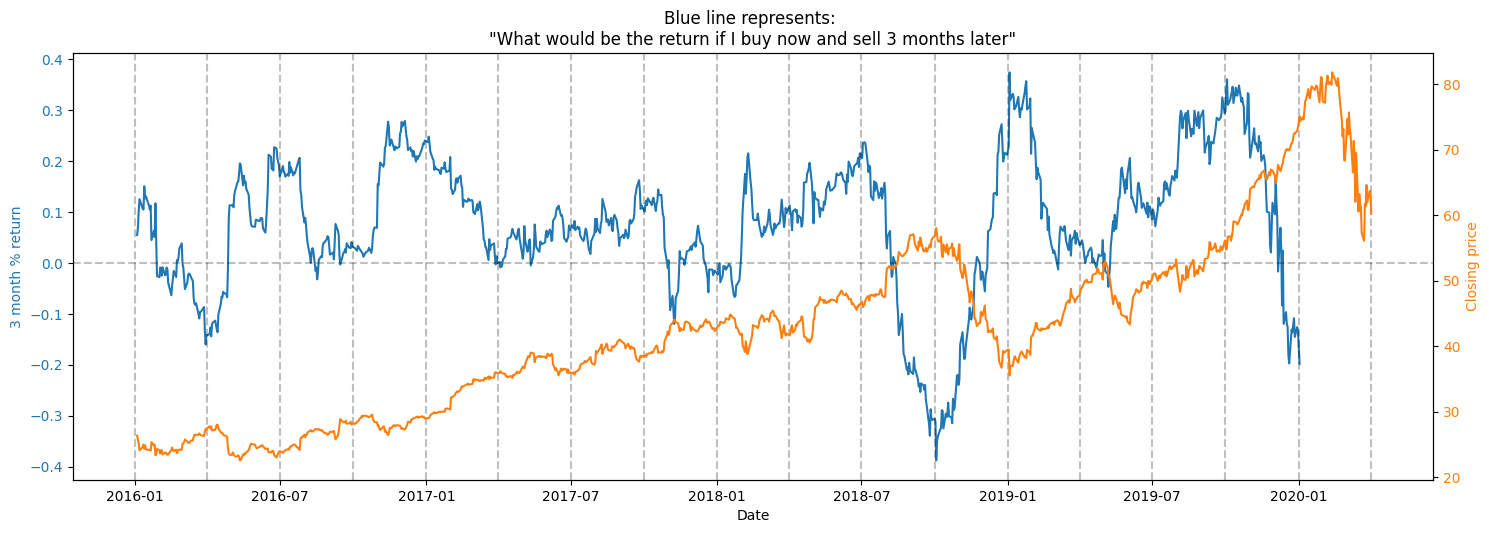

In [69]:
# double axis plot using closing price and volumne traded on second axis.
# Closing price in blue and volume in orange
# dates should be every 6 months

fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('3 month % return', color=color)
ax1.plot(aapl_stock_data['3month_return'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.25)

# show two vertical lines where one is the max 3 month return point, and the other is three months before that
# max_3month_return_date = aapl_stock_data['3month_return'].idxmax()
# ax1.axvline(x=max_3month_return_date, color='black', linestyle='--', alpha=0.2)
# ax1.axvline(x=max_3month_return_date - pd.Timedelta(days=90), color='black', linestyle='--', alpha=0.2)


# Make a grid that has vertical lines on every 3 months starting from the first date
start_date = aapl_stock_data.index[0]
end_date = aapl_stock_data.index[-1]
date_range = pd.date_range(start_date - pd.Timedelta(days=3), end_date, freq='3MS')
for date in date_range:
    ax1.axvline(x=date, color='black', linestyle='--', alpha=0.25)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Closing price', color=color)  # we already handled the x-label with ax1
ax2.plot(aapl_stock_data['Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Blue line represents: \n"What would be the return if I buy now and sell 3 months later"')
plt.show()